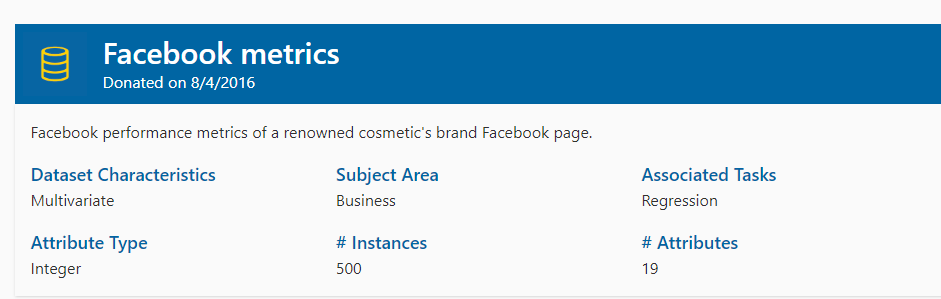

    

## Objectives

After completing this lab you will be able to:

* Use statsmodel to implement Multiple Linear Regression
* And learn about OLS


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#understanding-data">Understanding the Data</a></li>
        <li><a href="#reading_data">Reading the Data in</a></li>
        <li><a href="#multiple_regression_model">Multiple Regression Model</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


### Importing Needed packages


In [1]:
import numpy as np # scientific computing for multidimensional array
import pandas as pd # wrangling and enchancing numpy
import scipy # scientific python
import statsmodels.api as sm # statistical analysis
import matplotlib.pyplot as plt # visualization
import seaborn as sns # advanced statistical visuaization
sns.set() # over write the graphics of all the matplotlib plot
import sklearn # machine learn
%matplotlib inline

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


<h2 id="understanding_data">Understanding the Data</h2>

### `dataset_Facebook.csv`:
The data is related to posts' published during the year of 2014 on the Facebook's page of a renowned cosmetics brand.
This dataset contains 500 of the 790 rows and part of the features analyzed by Moro et al. (2016). The remaining were omitted due to confidentiality issues. [Dataset source](https://archive.ics.uci.edu/dataset/368/facebook+metrics)

<h2 id="reading_data">Reading the data in</h2>


In [2]:
df = pd.read_csv('dataset_Facebook.csv')

# take a look at the dataset
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [3]:
# data shape
df.shape

(500, 19)

In [4]:
# misssing values
df.isna().sum()

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [5]:
# drop missing values
df_new = df.dropna()

In [6]:
# check the df_new for any missing values
df_new.isna().sum()

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

### Let's select some features that we want to use for regression.


In [7]:
# create a list of subset features for the first 7 konw to predict the Total interactions
features = ['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid']

The above features are known prior to the post publication, and our goal is to predict the Total interactions.

In [8]:
# full features
full_features = df.columns.tolist()[:18] 
print('List of full features: ', full_features)

List of full features:  ['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid', 'Lifetime Post Total Reach', 'Lifetime Post Total Impressions', 'Lifetime Engaged Users', 'Lifetime Post Consumers', 'Lifetime Post Consumptions', 'Lifetime Post Impressions by people who have liked your Page', 'Lifetime Post reach by people who like your Page', 'Lifetime People who have liked your Page and engaged with your post', 'comment', 'like', 'share']


### Now let's plot a correlation matrix to see if there's any multicolinearity.

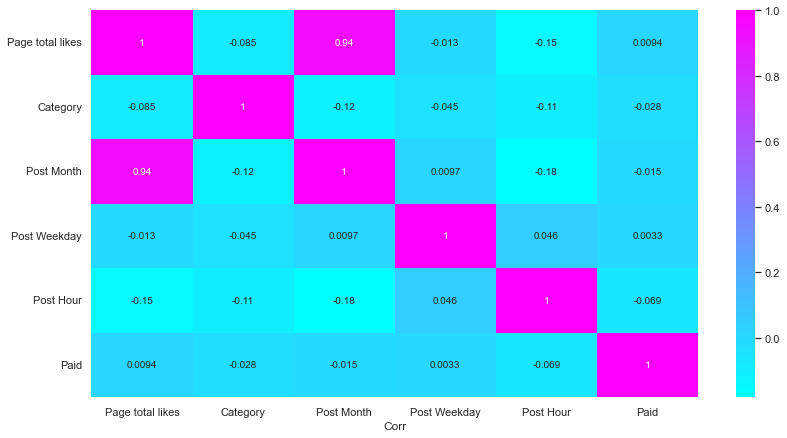

In [9]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(df_new[features].corr(), annot=True,cmap=plt.cm.cool)
plt.tight_layout()
plt.xlabel('Corr')
plt.show()

**Note:** if you take a look at the correlation matrix plot you'll find out that there's is strong correlation between 'past month' and 'page total likes', however we will leave for now.

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the  __np.random.rand()__ function: 


In [10]:
# new subset dataframe abbrevation of facebook metrics df
fmdf = df_new.copy()
fmdf.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


### Let us lebal encode the Type column 

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
fmdf['Type'] = le.fit_transform(fmdf['Type'])
fmdf.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


### Assign to target and input:

In [22]:
input = fmdf[features]
target = fmdf['Total Interactions']

**Note:** do not scale the 'type' feature because it's it label encoded.

In [23]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#input.loc[:,['Page total likes', 'Category', 'Post Month', 'Post Weekday','Post Hour', 'Paid']] = scaler.fit_transform(input[['Page total likes', 'Category', 'Post Month', 'Post Weekday','Post Hour', 'Paid']].to_numpy())

In [24]:
input[0:1]

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid
0,139441,1,2,12,4,3,0.0


<h2 id="multiple_regression_model">Multiple Regression Model</h2>


In [25]:
x = sm.add_constant(input) # statsmodels add a constant or the intercept value
results = sm.OLS(target,x).fit() # fit ordinary least square method x and y/target

### Results

In [26]:
# display a summary result of the model using the .summary method
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Total Interactions   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.766
Date:                Sun, 13 Aug 2023   Prob (F-statistic):            0.00793
Time:                        12:16:14   Log-Likelihood:                -3634.8
No. Observations:                 495   AIC:                             7286.
Df Residuals:                     487   BIC:                             7319.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -276.3226    289.582     -0.954      0.340    -845.308     292.662
Page total likes     0.0040      0.003      1.281      0.201      -0.002       0.010
Type                27.4253     40.455      0.678      0.498     -52.063     106.913
Category            53.7144     20.408      2.632      0.009      13.616      93.813
Post Month         -14.9125     15.504     -0.962      0.337     -45.376      15.551
Post Weekday       -12.9751      8.389     -1.547      0.123     -29.458       3.508
Post Hour           -0.2676      4.009     -0.067      0.947      -8.146       7.610
Paid                88.7639     37.968      2.338      0.020      14.162     163.366
==============================================================================
Omnibus:                      819.618   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           391887.368
Skew:                           9.608   Prob(JB):                         0.00
Kurtosis:                     139.497   Cond. No.                     2.13e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **Practice:**

Use the full_features to see if there's any improvement in the result or the R_square and Adj. R_square.

<details><summary><h3>Click here for the solution</h3></summary>

```python

# target/inputs
input = fmdf[full_features]
target = fmdf['Total Interactions']

    
# feature scale the values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
input.loc[:,['Page total likes', 'Category', 'Post Month', 'Post Weekday','Post Hour', 'Paid']] = scaler.fit_transform(input[['Page total likes', 'Category', 'Post Month', 'Post Weekday','Post Hour', 'Paid']].to_numpy())
    
# check the scaled inputs
input[0:1]
    
# the OLS model
x = sm.add_constant(input) # statsmodels add a constant or the intercept value
results = sm.OLS(target,x).fit() # fit ordinary least square method x and y/target

# display a summary result of the model using the .summary method
results.summary()
    

```

</details>